# Reprojection while Preserving Gradients
Below is a simple implementation demonstrating that passing the `requires_grad = True` flag allows for accumulation of gradients through reprojection.

In [1]:
!pip install sunpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.7 MB/s eta 0:00:00a 0:00:01


In [2]:
import sys
sys.path.append('../src')  # Adds the parent directory to the Python path
from astropy.io import fits
from astropy.wcs import WCS
from dfreproject import calculate_reprojection
from sunpy.data.sample import AIA_193_JUN2012, STEREO_A_195_JUN2012
import matplotlib.pyplot as plt
import torch
from astropy.io.fits import PrimaryHDU
from dfreproject import TensorHDU

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

AIA20120601_000007_0193_lowres.fits:   0%|          | 0.00/996k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Exception ignored in: <function BaseEventLoop.__del__ at 0x70f7397401f0>
Traceback (most recent call last):
  File "/home/carterrhea/anaconda3/envs/astro/lib/python3.10/asyncio/base_events.py", line 690, in __del__
    self.close()
  File "/home/carterrhea/anaconda3/envs/astro/lib/python3.10/asyncio/unix_events.py", line 71, in close
    self.remove_signal_handler(sig)
  File "/home/carterrhea/anaconda3/envs/astro/lib/python3.10/asyncio/unix_events.py", line 160, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/carterrhea/anaconda3/envs/astro/lib/python3.10/signal.py", line 56, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter


20120601_000530_n4eua.fits:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

<class 'dfreproject.tensorhdu.TensorHDU'>


keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-AVG to 56079.003875 from DATE-AVG.
Set MJD-END to 56079.003922 from DATE-END'. [astropy.wcs.wcs]


torch.Size([2048, 2048])
True
tensor([[4.7533, 4.2316, 3.0126,  ..., 3.8816, 4.0438, 4.2647],
        [3.8887, 2.7438, 2.2698,  ..., 2.5023, 2.4245, 3.4351],
        [3.7407, 2.2585, 1.8996,  ..., 2.2776, 1.9588, 2.9889],
        ...,
        [3.0123, 2.5461, 2.2326,  ..., 2.4827, 2.4784, 3.0472],
        [2.4259, 2.3600, 2.0683,  ..., 2.1259, 2.1172, 3.0038],
        [5.6875, 3.5573, 2.8059,  ..., 3.6285, 3.1336, 4.4468]],
       dtype=torch.float64)


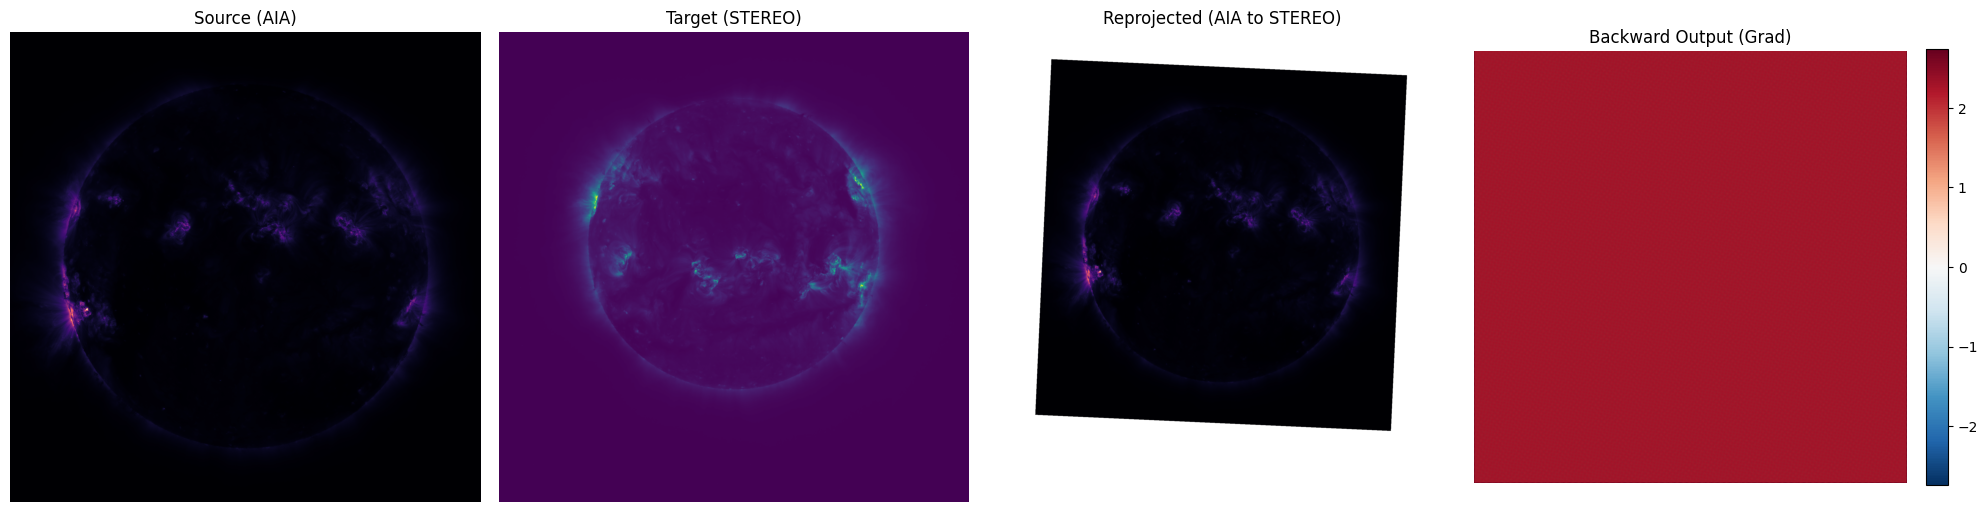

In [3]:
# Load source and target images
source_hdu = fits.open(AIA_193_JUN2012)[1]
target_hdu = fits.open(STEREO_A_195_JUN2012)[1]
source_hdu = PrimaryHDU(source_hdu.data, header=source_hdu.header)

source_hdu = TensorHDU(torch.tensor(source_hdu.data, requires_grad=True), source_hdu.header)
alt_tensor = source_hdu.tensor 
alt_header = source_hdu.header
target_hdu = PrimaryHDU(target_hdu.data, header=target_hdu.header)

target_wcs = WCS(target_hdu.header)

print(type(source_hdu))



reprojected = calculate_reprojection(
    source_hdus = source_hdu,
    target_wcs=target_wcs,
    shape_out=target_hdu.data.shape,
    order='bilinear',
    requires_grad=True,
)

print(reprojected.shape)  # Should match target_hdu.data.shape


print(reprojected.requires_grad)  # Should be True if requires_grad=True was passed
reprojected.sum().backward()
print(source_hdu.tensor.grad)
# Plot with a diverging colormap centered at zero for gradients
import numpy as np

grad = source_hdu.tensor.grad.cpu().numpy()
# Use percentiles to avoid outlier-dominated color scaling
vmax = np.nanpercentile(np.abs(grad), 99)
if vmax == 0 or np.isnan(vmax):
    vmax = 1e-8  # fallback to avoid division by zero

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(source_hdu.data, cmap='magma')
axes[0].set_title('Source (AIA)')
axes[1].imshow(target_hdu.data, cmap='viridis')
axes[1].set_title('Target (STEREO)')
axes[2].imshow(reprojected.detach(), cmap='magma')
axes[2].set_title('Reprojected (AIA to STEREO)')
im = axes[3].imshow(grad, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[3].set_title('Backward Output (Grad)')
for ax in axes:
    ax.axis('off')
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()